# Hidden-Shift Problem for Bent Functions

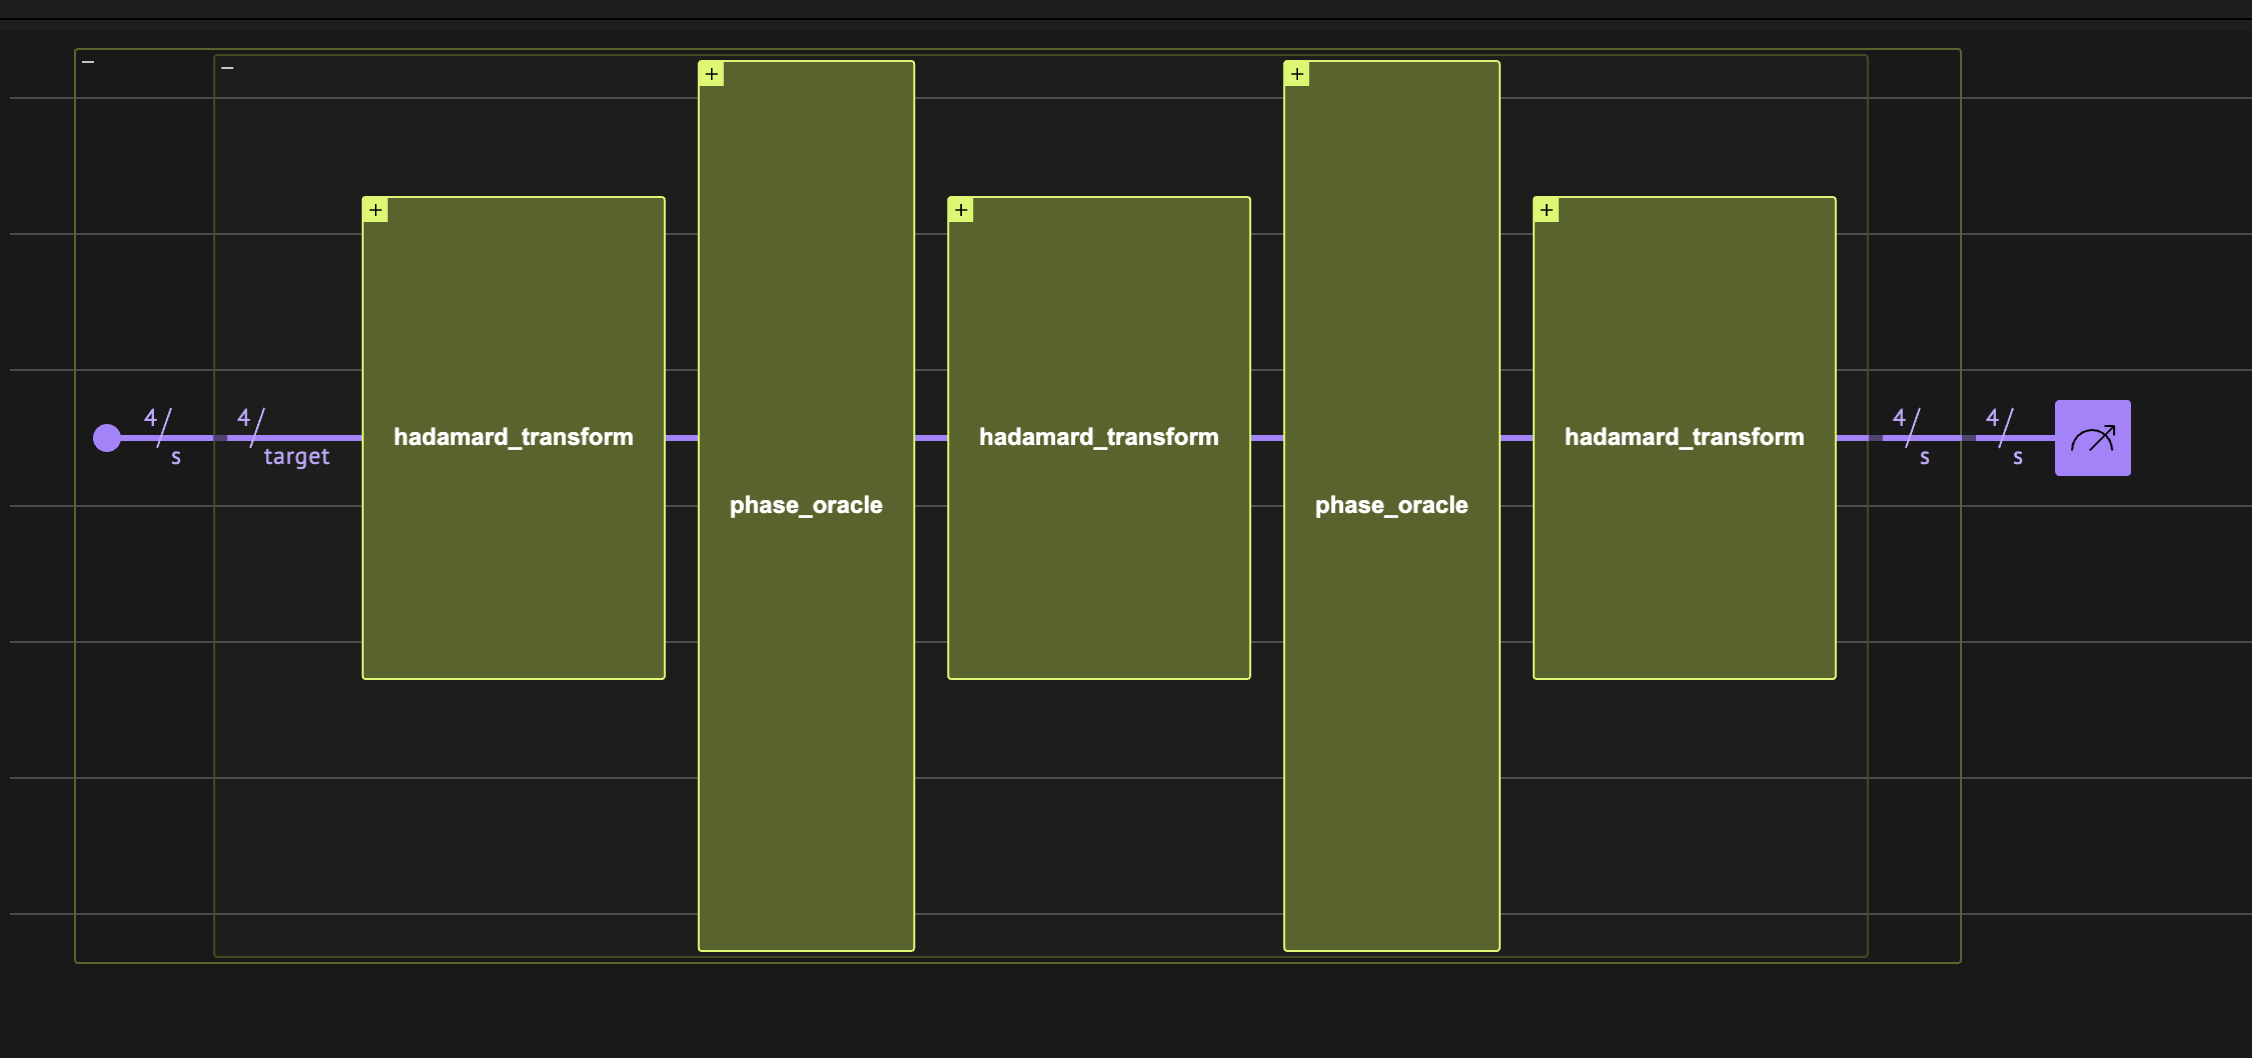

Here we implement the hidden shift algorithm for the family of Boolean bent functions using the Classiq platform.

Make sure we have all necessary packages:

In [ ]:
!pip install galois

We assume we know how to implement the dual of $f$ and get $s$ according to the algorithm in [[1](#first)]: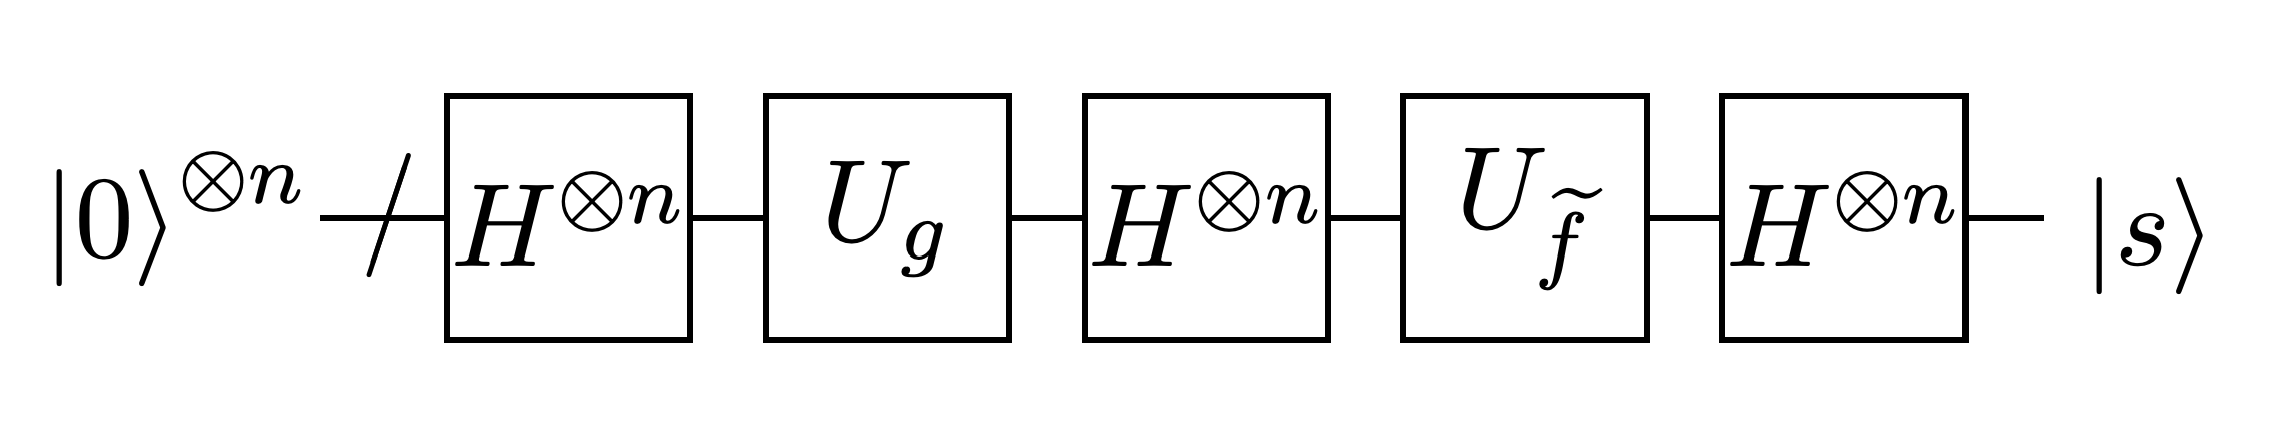

In [1]:
from classiq import *


@qfunc
def hidden_shift(
    oracle: QCallable[QArray],
    oracle_shifted: QCallable[QArray],
    target: QArray,
) -> None:
    hadamard_transform(target)
    oracle_shifted(target)
    hadamard_transform(target)
    oracle(target)
    hadamard_transform(target)


NUM_VARIABLES = 4


@qfunc
def main(s: Output[QArray]) -> None:

    @qperm
    def arith_func(vars: Const[QArray[QBit, NUM_VARIABLES]], res: QBit):
        res ^= (vars[0] & vars[1]) ^ (vars[2] & vars[3])

    @qperm
    def arith_func_shifted(vars: Const[QArray[QBit, NUM_VARIABLES]], res: QBit):
        res ^= ((vars[0] ^ 1) & vars[1]) ^ (vars[2] & vars[3])

    allocate(NUM_VARIABLES, s)

    hidden_shift(
        lambda y: phase_oracle(arith_func, y),
        lambda y: phase_oracle(arith_func_shifted, y),
        s,
    )


constraints = Constraints(optimization_parameter="width")
qmod_simple = create_model(main, constraints, out_file="hidden_shift_simple")
qprog_simple = synthesize(qmod_simple)
show(qprog_simple)

Quantum program link: https://platform.classiq.io/circuit/32pMyZ4KsLkk15xFLwNWE3aPWER


In [2]:
sample_results_simple = execute(qprog_simple).result_value()
sample_results_simple.counts_of_output("s")

{'1000': 2048}

## More Complex Functions

We take a Maiorana-McFarland function with random permutation on the `y` and `h` function is the `and` operation between all the y-variables.

In [3]:
import random
from functools import reduce

import numpy as np

NUM_VARIABLES = 16

# Define the list
my_list = list(range(NUM_VARIABLES // 2))

# Get a random permutation
random.seed(1)
random.shuffle(my_list)

# Create a permutation dict and its inverse
perm_dict = {i: my_list[i] for i in range(NUM_VARIABLES // 2)}
inverse_perm_dict = {v: k for k, v in perm_dict.items()}


def h(y):
    return reduce(lambda a, b: a & b, [y[i] for i in range(NUM_VARIABLES // 2)])


def h_dual(x):
    return reduce(
        lambda a, b: a & b, [x[inverse_perm_dict[i]] for i in range(NUM_VARIABLES // 2)]
    )


def f_func(x, y):
    return (
        reduce(
            lambda a, b: a ^ b,
            [x[i] & y[perm_dict[i]] for i in range(NUM_VARIABLES // 2)],
        )
    ) ^ h(y)


def f_dual_func(x, y):
    return (
        reduce(
            lambda a, b: a ^ b,
            [x[inverse_perm_dict[i]] & y[i] for i in range(NUM_VARIABLES // 2)],
        )
    ) ^ h_dual(x)


def shifted(x, y, bits):
    x = [x[i] for i in range(NUM_VARIABLES // 2)]
    y = [y[i] for i in range(NUM_VARIABLES // 2)]

    for bit in bits:
        if bit < NUM_VARIABLES >> 2:
            x[bit] = x[bit] ^ 1
        else:
            bit = bit - NUM_VARIABLES // 2
            y[bit] = y[bit] ^ 1
    return f_func(x, y)

In [4]:
shifted_bits = [1, 3, 9]
g_func = lambda x, y: shifted(x, y, shifted_bits)

## Creating the Circuit

In [9]:
@qperm
def g_qfunc(s: Const[QArray], res: QBit):
    res ^= g_func(s[0 : NUM_VARIABLES // 2], s[NUM_VARIABLES // 2 : s.len])


@qperm
def f_dual_qfunc(s: Const[QArray], res: QBit):
    res ^= f_dual_func(s[0 : NUM_VARIABLES // 2], s[NUM_VARIABLES // 2 : s.len])


@qperm
def f_qfunc(s: Const[QArray], res: QBit):
    res ^= f_func(s[0 : NUM_VARIABLES // 2], s[NUM_VARIABLES // 2 : s.len])


@qfunc
def main(s: Output[QArray]) -> None:
    allocate(NUM_VARIABLES, s)

    hidden_shift(
        lambda y: phase_oracle(f_dual_qfunc, y),
        lambda y: phase_oracle(g_qfunc, y),
        s,
    )


qmod_complex = create_model(
    main, constraints=constraints, out_file="hidden_shift_complex"
)  # same constraints
qprog_complex = synthesize(qmod_complex)
show(qprog_complex)

Quantum program link: https://platform.classiq.io/circuit/32pN1MxOPfC7NEHH3ikKDLNzBxn


In [10]:
sample_results_complex = execute(qprog_complex).result_value()
sample_results_complex.counts_of_output("s")

{'0101000001000000': 2048}

In [11]:
expected_s = "".join("1" if i in shifted_bits else "0" for i in range(NUM_VARIABLES))
assert list(sample_results_complex.counts_of_output("s").keys())[0] == expected_s

And indeed we got the correct shift!

## Hidden Shift Without the Dual Function

We now use the second algorithm described in [[2](#second)]. This algorithm only requires implementing $f$ and not its dual; however, it requires $O(n)$ samples from the circuit.
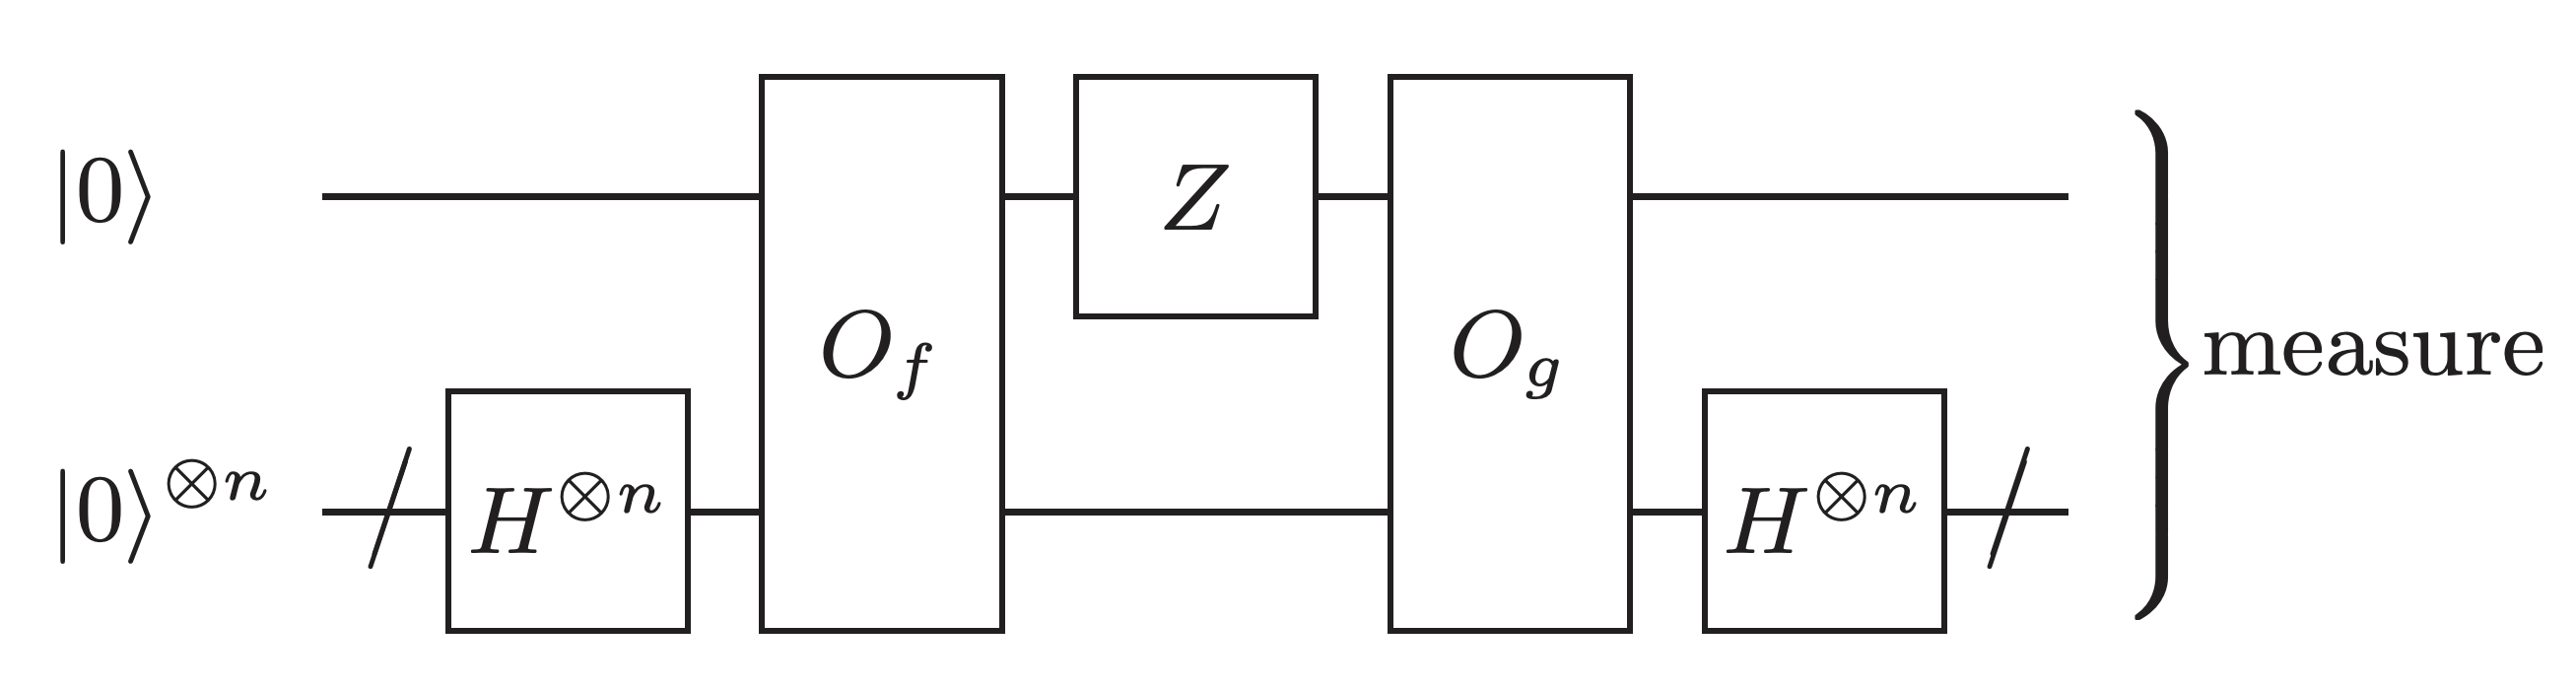

In [17]:
@qfunc
def hidden_shift_no_dual(
    oracle: QCallable[QArray, QBit],
    oracle_shifted: QCallable[QArray, QBit],
    target: QArray,
    ind: QBit,
) -> None:
    hadamard_transform(target)
    oracle(target, ind)
    Z(ind)
    oracle_shifted(target, ind)
    hadamard_transform(target)


NUM_VARIABLES = 16


@qfunc
def main(target: Output[QArray], ind: Output[QBit]) -> None:

    allocate(NUM_VARIABLES, target)
    allocate(ind)

    hidden_shift_no_dual(f_qfunc, g_qfunc, target, ind)


qmod_no_dual = create_model(
    main, constraints=constraints, out_file="hidden_shift_no_dual"
)  # same constraints
qprog_no_dual = synthesize(qmod_no_dual)
show(qprog_no_dual)

Quantum program link: https://platform.classiq.io/circuit/32pN4RYsZBWhYnMRzZCMwaUAUxR


In [18]:
sample_results_no_dual = execute(qprog_no_dual).result_value()

Out of the sampled results, we look for $n$ independent samples, from which we can extract s.
One thousand samples should be enough with a very high probability.

In [19]:
# The galois library is a package that extends NumPy arrays to operate over finite fields.
# we will use it as our equations are binary equations
import galois

# here we work over Boolean arithmetics - F(2)
GF = galois.GF(2)


def is_independent_set(vectors):
    matrix = GF(vectors)
    rank = np.linalg.matrix_rank(matrix)
    if rank == len(vectors):
        return True
    else:
        return False


samples = [
    ([int(i) for i in u], int(b))
    for u, b in sample_results_no_dual.counts_of_multiple_outputs(
        ["target", "ind"]
    ).keys()
]

ind_v = []
ind_b = []
for v, b in samples:
    if is_independent_set(ind_v + [v]):
        ind_v.append(v)
        ind_b.append(b)
        if len(ind_v) == len(v):
            # reached max set
            break

assert len(ind_v) == len(v)

We now solve the equation and extract $s$:

In [15]:
A = np.array(ind_v)
b = np.array(ind_b)

# Solve the linear system
s = np.linalg.solve(GF(A), GF(b))
s

GF([0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], order=2)

And we successfully received the same shift.

In [16]:
assert "".join(str(i) for i in s) == expected_s

## References

<a id='first'>[1]</a>: [Quantum algorithms for highly non-linear Boolean functions](https://arxiv.org/abs/0811.3208)

<a id='second'>[2]</a>: [Quantum algorithm for the Boolean hidden shift problem](https://arxiv.org/abs/1103.3017)
